In [1]:
# load packages
from __future__ import print_function, division
from operator import itemgetter
import os
import time
import numpy as np
import pdb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
plt.ion()   # interactive mode


In [2]:
torch.cuda.is_available()

True

In [3]:
class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.04, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=True):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
       # img_max = 6000
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list
    

        
    
        

class IMBALANCECIFAR100(IMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100

In [4]:
# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([
        # TODO 1, data transform for train set. Use RandomHorizontalFlip function for data augumentation
        ################################ TODO ##################################
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ################################ TODO ##################################
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
}


In [5]:
torch.cuda.set_device('cuda:0')

In [6]:
# Load CIFAR10 (imbalanced)

image_datasets= {'train': IMBALANCECIFAR10(root='./data', train=(True), download=True, transform=data_transforms['train']), 'test': torchvision.datasets.CIFAR10(root='./data', train=(False), download=True, transform=data_transforms['test'])}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'), num_workers=16) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
#print(dataset_sizes)
# Move to GPU
device = torch.device("cuda:0")


Files already downloaded and verified
Files already downloaded and verified


In [7]:
torch.cuda.get_device_name()

'NVIDIA TITAN Xp'

In [8]:
torch.cuda.current_device()

0

In [9]:
torch.cuda.get_device_capability()

(6, 1)

In [10]:
torch.cuda.device_count()

2

In [11]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1542539599a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x154253959f70>}

In [12]:

#image_datasets['train'].get_cls_num_list()
print(dict(Counter(image_datasets['test'].targets)))
print(dict(Counter(image_datasets['train'].targets)))

{3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}
{0: 5000, 1: 3496, 2: 2445, 3: 1709, 4: 1195, 5: 836, 6: 584, 7: 408, 8: 285, 9: 200}


In [13]:

class MyNet(nn.Module):

    def __init__(self):
        super(MyNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, (3,3), stride=(1,1),padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False),            
            
            nn.Conv2d(64, 128, (3,3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            
            nn.Conv2d(128, 128, (3,3),padding=1),
            nn.BatchNorm2d(128),            
            nn.ReLU(),
            
            nn.MaxPool2d(2, stride=2),            
            
            nn.Conv2d(128, 256, (3,3),padding=1),
            nn.BatchNorm2d(256),            
            nn.ReLU(),         
            
            nn.Conv2d(256, 256, (3,3),padding=1),
            nn.BatchNorm2d(256),            
            nn.ReLU(),  
            
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 512, (3,3),padding=1),
            nn.BatchNorm2d(512),            
            nn.ReLU(),
            
            nn.Conv2d(512, 512, (3,3),padding=1),
            nn.BatchNorm2d(512),            
            nn.ReLU(),
            
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(512, 512, (3,3),padding=1),
            nn.BatchNorm2d(512),            
            nn.ReLU(),
            
            nn.Conv2d(512, 512, (3,3),padding=1),
            nn.BatchNorm2d(512),            
            nn.ReLU(),
            
            nn.MaxPool2d(2, stride=2)
        )
        self.linear = nn.Sequential(
            nn.Linear(512,128),
            nn.Dropout(p=0.4),
            nn.Linear(128,10)
        )    
    def forward(self, x):

        x = self.convs(x)
        x = x.view(-1, 512)

        x = self.linear(x)
        return x



In [14]:
def train_model(model, criterion, optimizer, num_epochs, dataloader, size=None, save_path='saved_weight.pth'):
    since = time.time()
    loss_record = [] # Frost: for plot
    dataset_sizes_train = size
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                #import pdb; pdb.set_trace()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes_train
            epoch_acc = running_corrects.double() / dataset_sizes_train

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_record.append(epoch_loss)
            
        torch.save(model.state_dict(), save_path)
        model_test = model
        test_model(model_test, save_path)
    print()

    plt.plot(loss_record)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), save_path)
    model_test = model
    test_model(model, save_path)
    return model

In [15]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                ################################ TODO ##################################
                outputs = model(inputs)
                preds = torch.max(outputs, 1)[1]
                ################################ TODO ##################################

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return epoch_acc






      

In [16]:
def gen_accuracy_per_cls(model, load_path='saved_weight.pth'):
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    model.eval()   # Set model to evaluate mode


    accrcy_pr_clss = {}

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():

            outputs = model(inputs) 
            preds = torch.max(outputs, 1)[1]
            for i, y in zip(labels, preds):

                if i.item() not in accrcy_pr_clss:
                    if y == i:
                        accrcy_pr_clss[i.item()] = 1
                    else:
                        continue 
                else:
                    if y == i:
                        accrcy_pr_clss[i.item()] += 1
                    else:
                        continue
    sort = {}
    for i in range(10):
        for x in accrcy_pr_clss:
            if i == x:
                sort[i] = accrcy_pr_clss[x]

    return sort

In [17]:
class dataset_most_inform():
    def __init__(self, image_tensor, labels, transform=data_transforms, target_transform=None):
        self.img_labels = labels #list
        self.img_tensors = image_tensor #also list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_tensors[idx]
        label = self.img_labels[idx]

        return image, label


    
def sampling(model, dataset, load_path='saved_weight.pth'):
    model.load_state_dict(torch.load(load_path)) 
    cifar10 = dataset
    class_list = cifar10.get_cls_num_list()
    class_freq = {}
  
    for i, x in zip(cifar10.class_to_idx, class_list):
        class_freq[cifar10.class_to_idx[i]] = x
    
    #HARD CODED!!
    smallest = class_freq[5]

    #HARDCODED


    model.eval()   

    num_samples = smallest
    class_to_samples = {}
    for k in range(10):

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs) 
                preds = torch.max(outputs, 1)[1]
                softmax = nn.Softmax(dim=1)
                prob = softmax(outputs)
                #image by image
                for i, y, z, x in zip(prob, inputs, labels, preds):
                    if z.item() == k:
                        if k not in class_to_samples:
                            class_to_samples[k]= [[y, z, i[k]]]
                        else:
                            class_to_samples[k] += [[y, z, i[k]]]

    #HARDCODED!!
    no_sampling = [5, 6, 7, 8, 9]
    #HARDCODED!!
    dataset_dct = {}
     
    for i in class_to_samples:
        class_to_samples[i] = sorted(class_to_samples[i], key=itemgetter(2))
  
    for i in class_to_samples:
        if i in no_sampling:
            dataset_dct[i] = []
            for s in class_to_samples[i]: 
                dataset_dct[i] += [s]
                
        dataset_dct[i] = []
        count = 0
        for s in class_to_samples[i]:
            if count == smallest:
                break
            count += 1
            dataset_dct[i] += [s]
    
#     for i in dataset_dct:
#         for s in dataset_dct[i]:
#             print(len(dataset_dct[i]), s)
   
    lst_images = []
    lst_labels = []
    for i in dataset_dct:
        for s in dataset_dct[i]:
            lst_images.append(s[0])
            lst_labels.append(s[1])
   
    dataset_sampled = dataset_most_inform(lst_images, lst_labels)

    New_dataloader = {'train': torch.utils.data.DataLoader(dataset_sampled, batch_size=32, shuffle=True)}#, num_workers=16)}

    return New_dataloader, len(dataset_sampled)


      



In [18]:
cifar10 = IMBALANCECIFAR10(root='./data')
class_list = cifar10.get_cls_num_list()
class_freq = {}

for i, x in zip(cifar10.class_to_idx, class_list):
    class_freq[cifar10.class_to_idx[i]] = x

Files already downloaded and verified


In [19]:
class_freq


{0: 5000,
 1: 3496,
 2: 2445,
 3: 1709,
 4: 1195,
 5: 836,
 6: 584,
 7: 408,
 8: 285,
 9: 200}

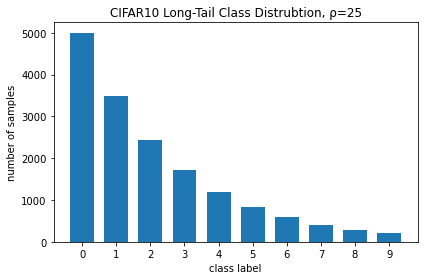

In [20]:
a = plt.bar([i for i in class_freq], [class_freq[i] for i in class_freq], width=0.7)
plt.ylabel('number of samples')
plt.xlabel("class label" )
plt.xticks([i for i in range(10)], [i for i in class_freq])
plt.title('CIFAR10 Long-Tail Class Distrubtion, ρ=25')
plt.tight_layout()
plt.savefig('/home/thafarma/figures/figures/class_distro_long-tail')
plt.show()


In [21]:
from copy import deepcopy
def MAL(model, criterion, optimizer, do_meta=False, eps=0.1,total_epochs=50, pretrained_epochs=25,inner_epochs=10, save_path='saved_weight.pth'):


    # pretrain the model
    train_model(model, criterion, optimizer, pretrained_epochs, dataloaders,dataset_sizes['train'], save_path)
    
    
    # load the data and sample the data
    cifar10 = IMBALANCECIFAR10(root='./data')
    meta_epochs = total_epochs - pretrained_epochs
    iter_1_loader, sampled_size = sampling(model, cifar10, save_path)
    original_datasize = dataset_sizes['train']
    
    # do the meta epochs  
    for meta_epoch in range(int(original_datasize*meta_epochs/(sampled_size*inner_epochs))):
        prev_model_params = deepcopy(model.state_dict())
        train_model(model, criterion, optimizer, inner_epochs, iter_1_loader, sampled_size, save_path)
        current_model_params = deepcopy(model.state_dict())
        #import pdb; pdb.set_trace()
        
        for param_name in current_model_params.keys():
            current_model_params[param_name] = (1-eps)*prev_model_params[param_name] + eps*current_model_params[param_name]
        if do_meta:
            model.load_state_dict(current_model_params)
        
        iter_1_loader, sampled_size = sampling(model, cifar10, save_path)



In [22]:
#summary(model_mynet_ft, (3,32,32))

# Experiments:
1. train the model on Balanced dataset, record the performance
2. train the model on imbalanced dataset, record the performance
3. train the model on imbalanced dataset, with iterative learning strategy
4. train the model on imbalanced dataset, with meta iterative learning strategy # do_mate=True

set the eps from 0.1 to 0.9. step size = 0.1, Record the best.

set the inner epochs from 5 to 20, step size=5.

use the accuracy, precision, recall, f1 score to measure the final performance. The detailed information is here.https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics


## Each experiments run 5 times. Record the mean and variance of each metrics.

### The most important thing: Reset the model parameters before excuting the steps.

Fixed hyperparameters: the transformation step is fixed.
    Total epoch = 50, pretrained_epochs=20, lr=1e-4
Flexible hyperparameters: 
    eps, inner_epochs, 
 

Epoch 0/20
----------
train Loss: 1.2329 Acc: 0.5762
test Acc: 0.3366
Testing complete in 0m 2s
Epoch 1/20
----------
train Loss: 0.9288 Acc: 0.6825
test Acc: 0.4925
Testing complete in 0m 2s
Epoch 2/20
----------
train Loss: 0.7565 Acc: 0.7424
test Acc: 0.5739
Testing complete in 0m 2s
Epoch 3/20
----------
train Loss: 0.6482 Acc: 0.7795
test Acc: 0.6155
Testing complete in 0m 2s
Epoch 4/20
----------
train Loss: 0.5503 Acc: 0.8163
test Acc: 0.6476
Testing complete in 0m 2s
Epoch 5/20
----------
train Loss: 0.4750 Acc: 0.8416
test Acc: 0.6472
Testing complete in 0m 2s
Epoch 6/20
----------
train Loss: 0.4100 Acc: 0.8624
test Acc: 0.6635
Testing complete in 0m 2s
Epoch 7/20
----------
train Loss: 0.3453 Acc: 0.8870
test Acc: 0.6997
Testing complete in 0m 2s
Epoch 8/20
----------
train Loss: 0.2922 Acc: 0.9036
test Acc: 0.7138
Testing complete in 0m 2s
Epoch 9/20
----------
train Loss: 0.2552 Acc: 0.9147
test Acc: 0.6581
Testing complete in 0m 2s
Epoch 10/20
----------
train Loss: 0.214

KeyboardInterrupt: 

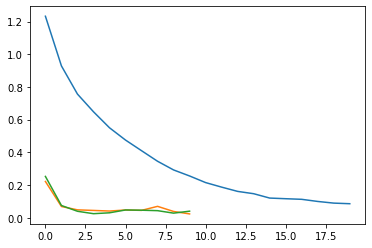

In [23]:
criterion = nn.CrossEntropyLoss()

#model_mynet_ft = train_model(model_mynet_ft, criterion, optimizer, 1, dataloaders, len(image_datasets['train']))

model1 = MyNet()
model1 = model1.to(device)

optimizer = optim.Adam(model1.parameters(), lr=1e-4)
model1 = MAL(model1, criterion, optimizer, do_meta=False, eps=0.5,total_epochs=50, pretrained_epochs=20,inner_epochs=10, save_path='AL.pth')
#train_model(model1, criterion, optimizer, 100, dataloaders, len(image_datasets['train']))

In [25]:
test_model(model1, "AL.pth")


test Acc: 0.7137
Testing complete in 0m 2s


tensor(0.7137, device='cuda:0', dtype=torch.float64)

In [26]:
AL_acc = gen_accuracy_per_cls(model1, 'AL.pth')
for i in range(len(AL_acc)):
     AL_acc[i] = AL_acc[i] / 1000
    
MAL_acc = gen_accuracy_per_cls(model1, 'MAL.pth' )
for i in range(len(MAL_acc)):
     MAL_acc[i] = MAL_acc[i] / 1000


In [27]:
AL_acc

{0: 0.932,
 1: 0.943,
 2: 0.709,
 3: 0.557,
 4: 0.805,
 5: 0.525,
 6: 0.782,
 7: 0.719,
 8: 0.622,
 9: 0.543}

In [28]:
MAL_acc

{0: 0.875,
 1: 0.974,
 2: 0.791,
 3: 0.702,
 4: 0.755,
 5: 0.553,
 6: 0.806,
 7: 0.652,
 8: 0.713,
 9: 0.575}

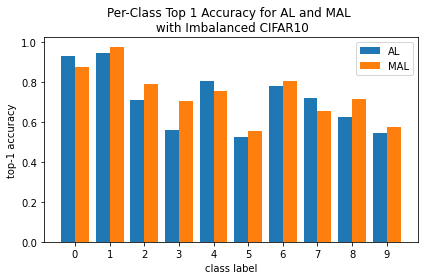

In [31]:
X = [i for i in range(10)]

AL = [AL_acc[i] for i in AL_acc]
MAL = [MAL_acc[i] for i in MAL_acc]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, AL, 0.4, label = 'AL')
plt.bar(X_axis + 0.2, MAL, 0.4, label = 'MAL')


plt.xticks(X_axis, X)
plt.xlabel("class label" )
plt.ylabel('top-1 accuracy')
plt.title('Per-Class Top 1 Accuracy for AL and MAL \n with Imbalanced CIFAR10')
plt.legend()
plt.tight_layout()
plt.savefig('/home/thafarma/figures/figures/AL_MAL')
plt.show()

In [ ]:
balanced = {0: 0.919,
 1: 0.947,
 2: 0.821,
 3: 0.769,
 4: 0.846,
 5: 0.787,
 6: 0.925,
 7: 0.928,
 8: 0.934,
 9: 0.927}